In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install darts

In [3]:
import pickle
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Tuple, Any, List, Dict
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from darts import TimeSeries
from darts.utils.statistics import (
    check_seasonality,
    plot_acf,
    plot_pacf)
from darts.metrics import (
    mse,
    mape
)
import darts
from darts.models import (
    LinearRegressionModel,
    NBEATSModel
)
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.utils.likelihood_models import (
    GaussianLikelihood,
    QuantileRegression
)
from darts.utils.losses import SmapeLoss
from statsmodels.graphics import tsaplots as tsaplots
import torch
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    StandardScaler,
    QuantileTransformer
)
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
import datetime as dt
import os
import warnings

plt.style.use("ggplot")
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")


%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%config Completer.use_jedi = False

In [43]:
DATA_DIR = "/content/drive/MyDrive/data"
RND_STATE = 192837
DT_FORMAT = "%Y-%m-%d"
PRED_TIME = dt.datetime(2013, 12, 31)
N_SAMPLES = 400  # for probabilistic forecasts

In [33]:
def train_test_split(
        series: Any,
        train_ratio: float = 0.8) -> Tuple[TimeSeries, Any]:
    if isinstance(series, pd.Series):
        series = pd.DataFrame(series)
    if not isinstance(series, TimeSeries):
        series = TimeSeries.from_dataframe(series)
    return series, series.split_before(train_ratio)


def preprocess(
        series: TimeSeries,
        transformer: Pipeline,
        train: TimeSeries,
        test: TimeSeries,
) -> Tuple[TimeSeries, TimeSeries, TimeSeries]:
    # Avoid fitting the transformer on the validation set.
    train_transformed = transformer.fit_transform(train)
    test_transformed, series_transformed = (transformer.transform(ser) for ser in (test, series))
    return series_transformed, train_transformed, test_transformed


def get_prediction(
        model: Any,
        pred_horizon: int,
        train_series: TimeSeries,
        predict_from: bool,
        num_samples: int) -> TimeSeries:
    if predict_from:
        return model.predict(n=pred_horizon, series=train_series, num_samples=num_samples)
    return model.predict(n=pred_horizon, num_samples=num_samples)


def evaluate_model(
        model: Any,
        train_series: TimeSeries,
        test_series: TimeSeries,
        pred_horizon: int,
        predict_from_train: bool = False,
        num_samples: int = 100,
        transformer: Pipeline = None,
        metrics: dict = None,
        plot: bool = True,
        n_digits: int = 2,
        plot_scale: float = 0.8
) -> Tuple[TimeSeries, TimeSeries, TimeSeries]:
    # Get prediction.
    pred_series = get_prediction(model, pred_horizon,
                                 train_series, predict_from_train, num_samples)
    # Inverse-transform TS if transformer was passed.
    if transformer is not None:
        train_series, test_series, pred_series = (
            transformer.inverse_transform(ser) for ser in
            (train_series, test_series, pred_series)
        )
    # Calculate metrics for back test and for test/validation.
    if metrics is None:
        metrics = dict(MSE=mse, MAPE=mape)
    metrics_test = {}
    for name, metric in metrics.items():
        metrics_test[name] = round(metric(pred_series, test_series), n_digits)
    # Plot results.
    if plot:
        plt.figure(figsize=np.array((8, 5)) * plot_scale)
        train_series.plot(label="train data")
        test_series.plot(label="test data")
        pred_series.plot(label="pred data")
        plt.legend()
        title = ""
        for name, metric in metrics_test.items():
            title += f" {name} = {metric} |"
        plt.title(title)
        plt.ylabel(train_series.columns[0])
        plt.xlabel(f"Time [{train_series.freq_str}]")
        plt.legend()
        plt.show()
    return train_series, test_series, pred_series


def extract_quantiles(forecast: TimeSeries) -> Tuple[TimeSeries]:
    quantiles = (0.025, 0.5, 0.975)
    data_ext = (forecast.quantile_timeseries(q).pd_series() for q in quantiles)
    df = pd.concat(data_ext, axis=1)
    df.columns = ["low", "mean", "high"]
    return df

In [25]:
# Prepare data
data = pd.read_csv(
    os.path.join(DATA_DIR, "data_cleaned.csv"),
    parse_dates=["Period"],
    date_parser=lambda x: pd.to_datetime(x, format=DT_FORMAT)
    ).set_index("Period")

# Resample to 1M and split.
series, (train, test) = train_test_split(
    data.unemp.resample("M").mean().interpolate())

# Scale.
transformer = Pipeline([
    Scaler(StandardScaler(), "StandardScaler")
])
series_scaled, train_scaled, test_scaled = preprocess(
    series, transformer, train, test)

In [49]:
# Calculate forecast horizon.
pred_series = pd.date_range(
    start=data.index.max(),
    end=PRED_TIME,
    freq="1M")[1:]
HORIZON = pred_series.shape[0]

In [50]:
# Prepare past covariates from inflation
past_cov = TimeSeries.from_series(
    data.infl.resample("M").mean().interpolate())
_, (train_cov, test_cov) = train_test_split(past_cov)
# Scale
transformer_cov = Pipeline([
    Scaler(StandardScaler(), "StandardScaler")
])
past_cov_scaled, train_cov_scaled, test_cov_scaled = preprocess(
    series, transformer_cov, train_cov, test_cov)

# Init and fit N-BEATS model

In [63]:
### N-BEATS hyper-parameters

# Slicing hyper-params:
IN_LEN = 30
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 20
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 136
COEFFS_DIM = 11

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 10
NUM_EPOCHS = 300

quantiles = np.arange(0.1, 1, 0.1)
quantiles = [0.025, 0.05] + [round(q, 2) for q in quantiles.tolist()] + [.95, .975]

In [64]:
%%time
np.random.seed(RND_STATE)
torch.manual_seed(RND_STATE)

nbeats = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    batch_size=BATCH_SIZE,
    optimizer_kwargs={"lr": LR},
    # likelihood=GaussianLikelihood(),
    likelihood=QuantileRegression(quantiles),
)
nbeats.fit(
    train_scaled,
    # past_covariates=past_cov_scaled,
    num_loader_workers=4,
    epochs=NUM_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | SmapeLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 887 K 
---------------------------------------------------
885 K     Trainable params
1.9 K     Non-trainable params
887 K     Total params
7.097     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


CPU times: user 55.1 s, sys: 56.1 s, total: 1min 51s
Wall time: 2min 43s


N-BEATS for unemployment timeseries evaluation on test


Predicting: 1it [00:00, ?it/s]

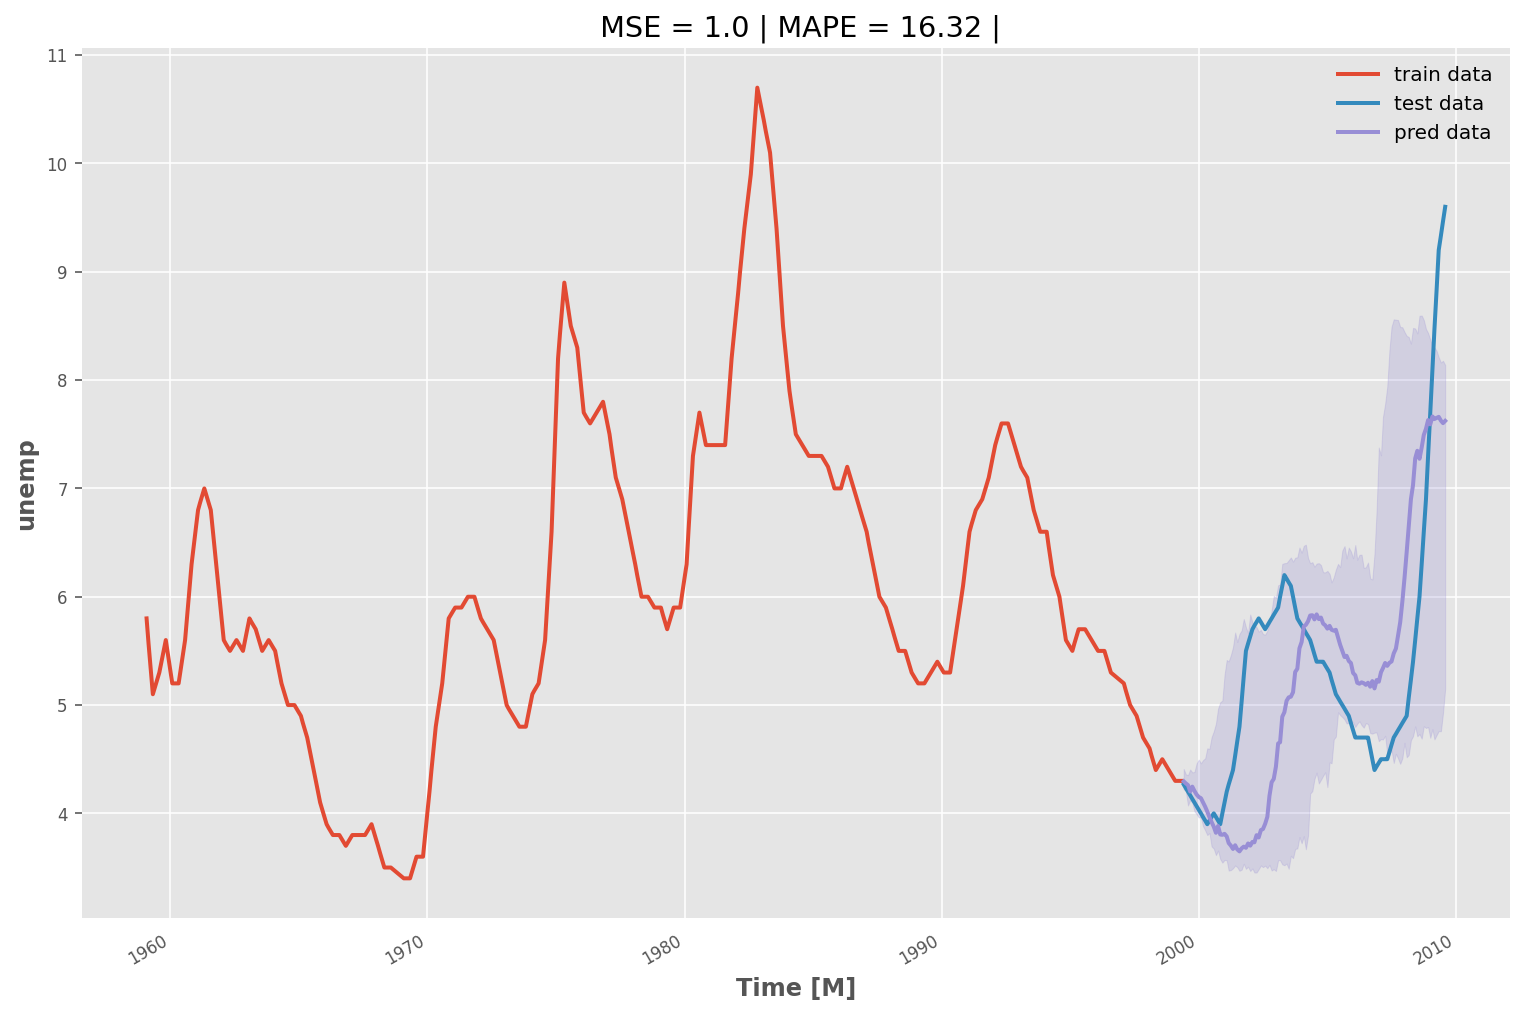

In [65]:
# Evaluate NBEATS for unemployment.
print("N-BEATS for unemployment timeseries evaluation on test")
_, _, pred_series = evaluate_model(
    nbeats,
    train_scaled,
    test_scaled,
    transformer=transformer,
    pred_horizon=len(test_scaled),
    predict_from_train=True,
    plot_scale=1.6)

In [69]:
# Save unemployment test performance data to csv.
df_pred = extract_quantiles(pred_series)
df_unemp_test = pd.DataFrame(pd.concat(
    [df_pred, train.pd_dataframe(), test.pd_dataframe()
    ], axis=1)
).rename({"unemp": "unemployment_train",
          "unemp.1": "unemployment_test"}, axis=1)
df_unemp_test.to_csv(os.path.join(DATA_DIR, "df_unemp_test.csv"))

### Here I'm also going to predict population timeseries with linear regression model.

LinearRegression for population timeseries evaluation on test


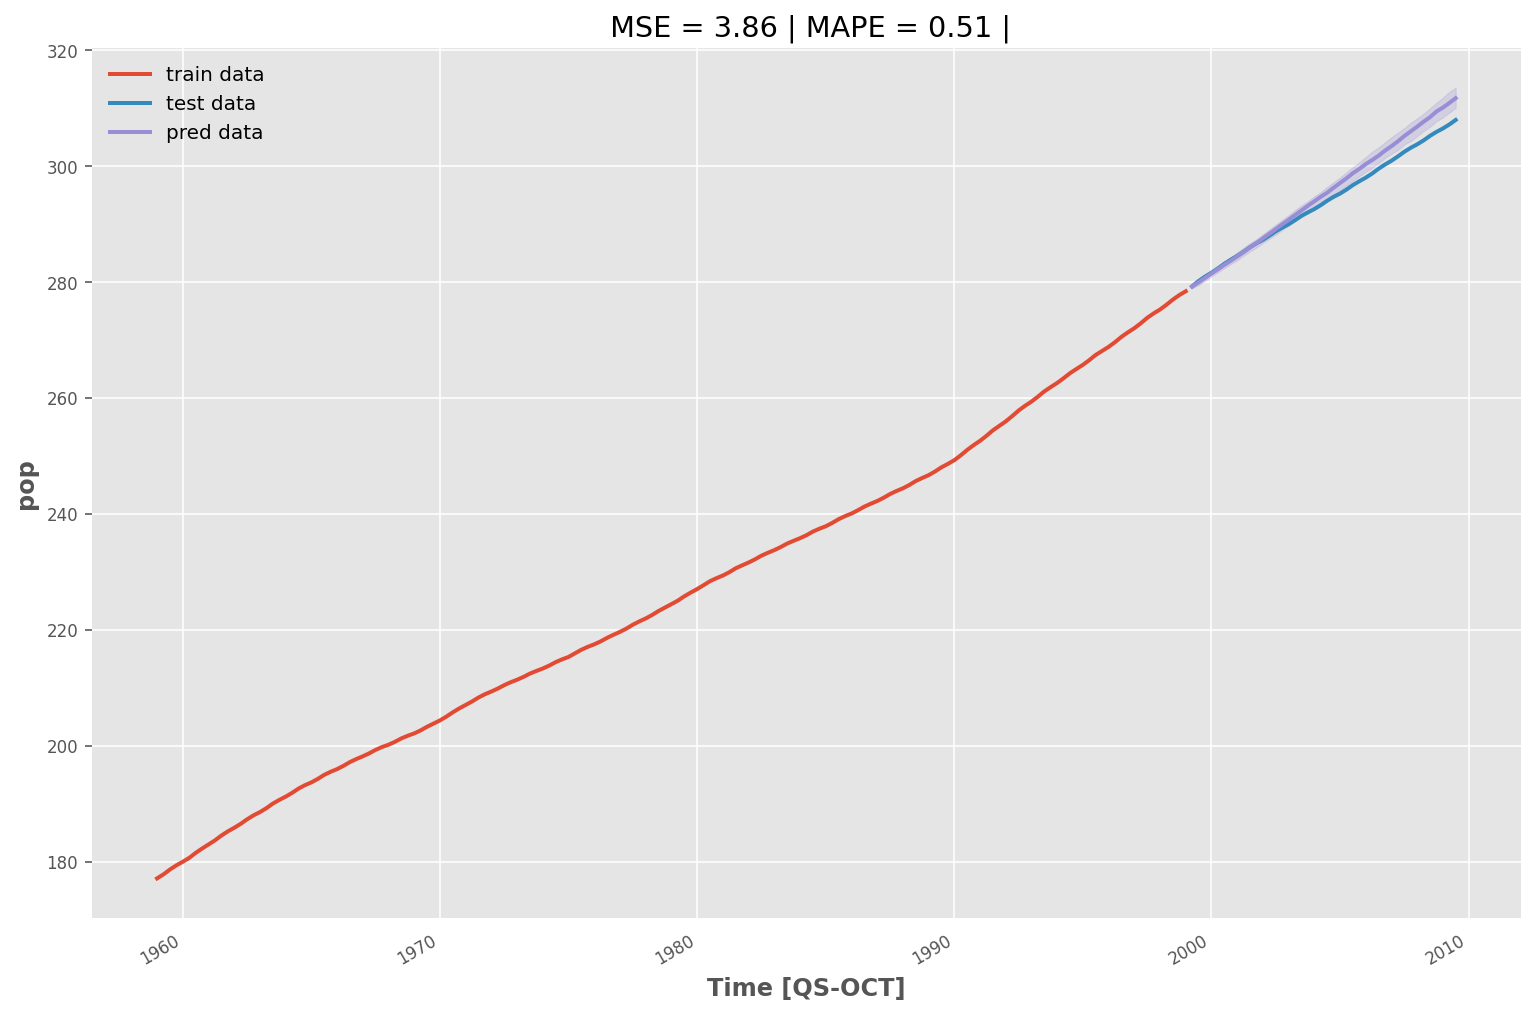

In [70]:
# Get population timeseries.
series_pop, (train_pop, test_pop) = train_test_split(data["pop"])
linreg = LinearRegressionModel(lags=30,
                              likelihood="quantile",
                              quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
linreg.fit(train_pop)
pred = linreg.predict(n=len(test_pop), num_samples=N_SAMPLES)
# Evaluate LinearRegression model.
print("LinearRegression for population timeseries evaluation on test")
_, _, pred_series = evaluate_model(
    linreg,
    train_pop,
    test_pop,
    pred_horizon=len(test_pop),
    predict_from_train=False,
    plot_scale=1.6)

In [74]:
# Save population test performance data to csv.
df_pred = extract_quantiles(pred_series)
df_pop_test = pd.DataFrame(pd.concat([
    df_pred, train_pop.pd_dataframe(), test_pop.pd_dataframe()
    ], axis=1)
).rename({"pop": "population_train",
          "pop.1": "population_test"}, axis=1)
df_pop_test.to_csv(os.path.join(DATA_DIR, "df_pop_test.csv"))

# Make a final prediction

In [75]:
# Unemployment forecast.
forecast_scaled = nbeats.predict(HORIZON, series=series_scaled, num_samples=N_SAMPLES)
forecast = transformer.inverse_transform(forecast_scaled)

# Population forecast.
forecast_pop = linreg.predict(HORIZON, series=series_pop, num_samples=N_SAMPLES)

Predicting: 1it [00:00, ?it/s]

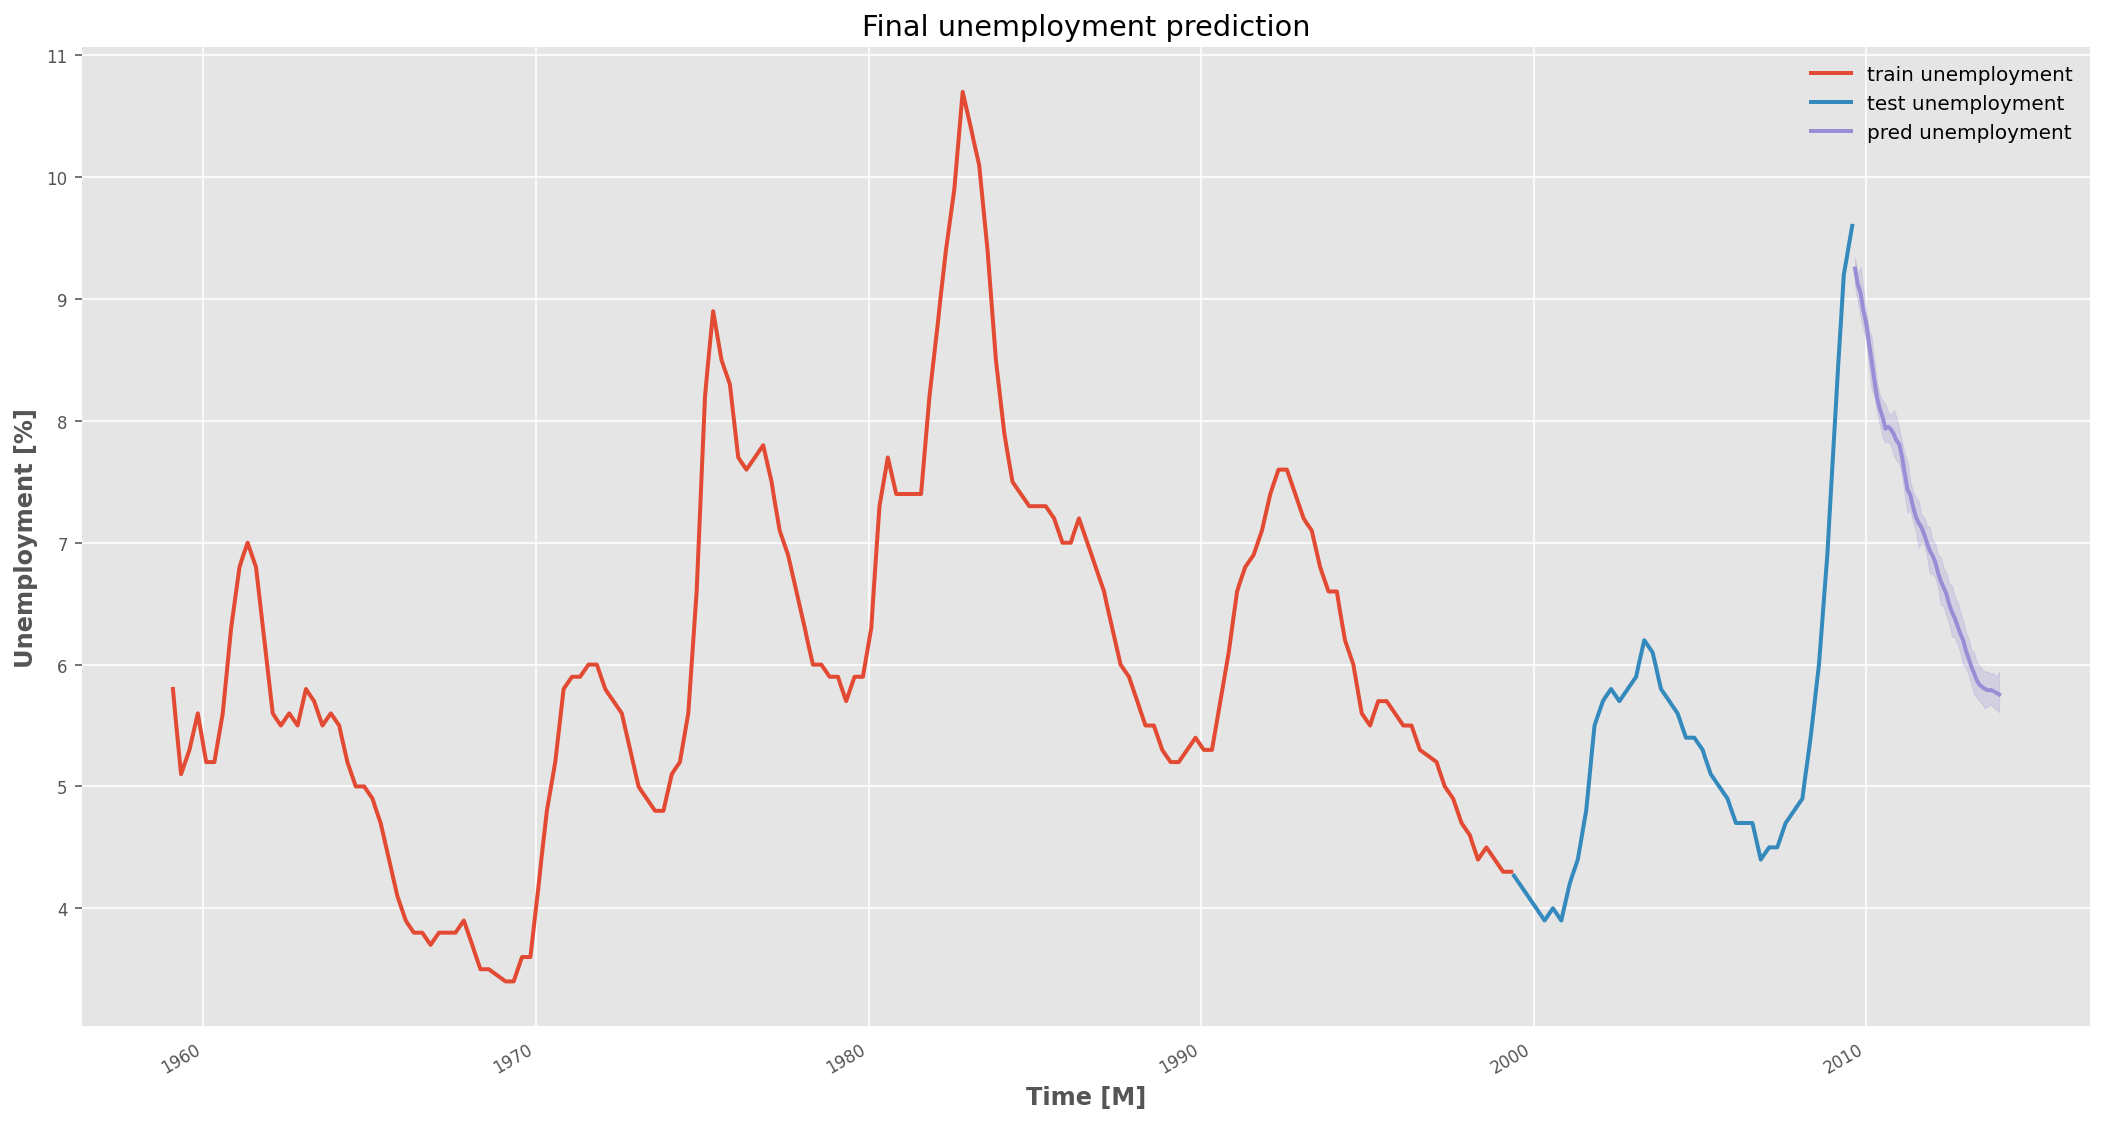

In [77]:
# Plot unemployment forecast.
series_name = "unemployment"
plot_scale = 1.5
fig = plt.figure(figsize=np.array([12, 6]) * plot_scale)
train.plot(label=f"train {series_name}")
test.plot(label=f"test {series_name}")
forecast.plot(label=f"pred {series_name}")
plt.title(f"Final {series_name} prediction")
plt.xlabel("Time [M]")
plt.ylabel("Unemployment [%]")
fig.savefig(os.path.join(DATA_DIR, "forecast_unemp.png"))
plt.legend();

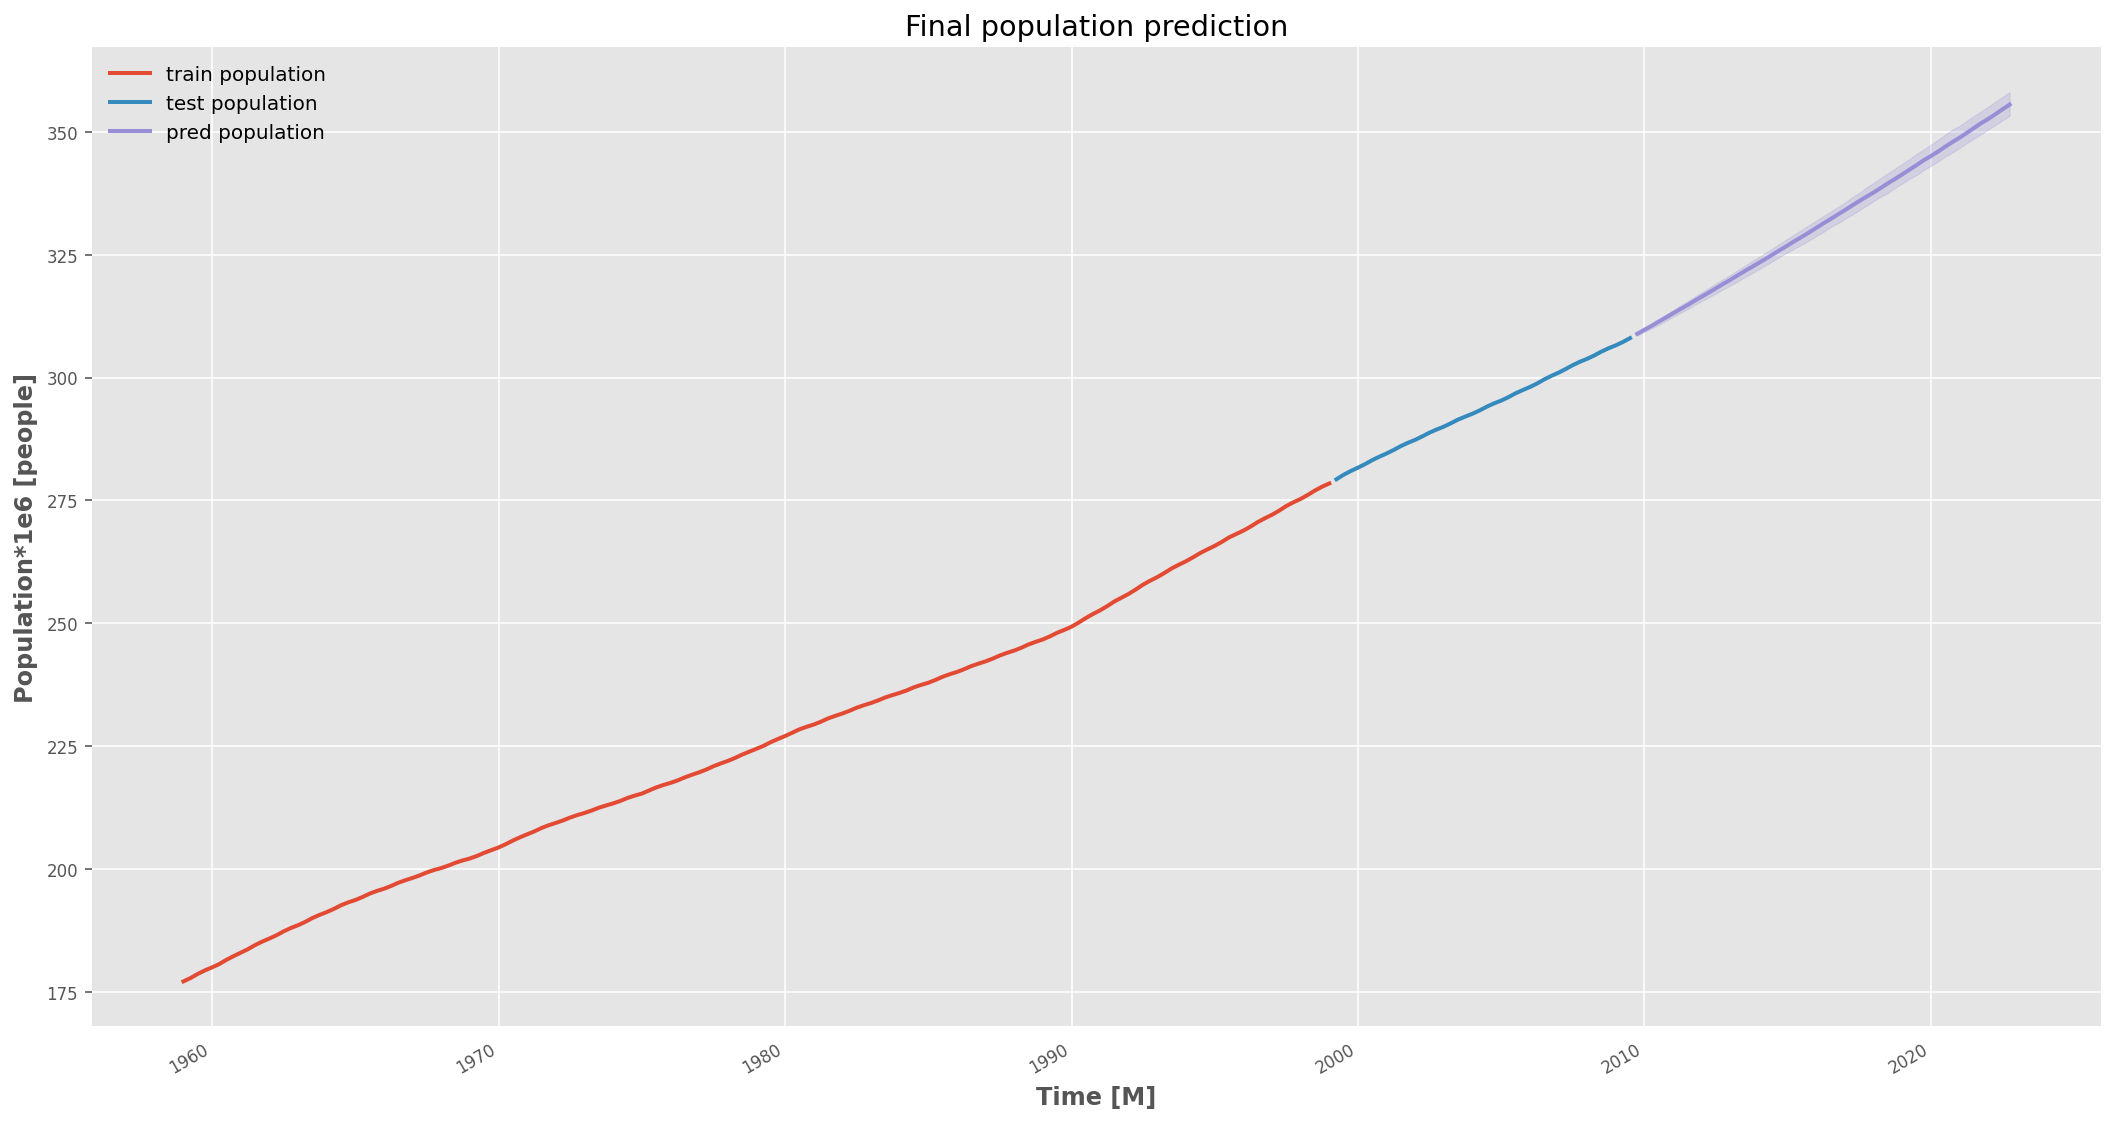

In [78]:
# Plot population forecast.
series_name = "population"
plot_scale = 1.5
fig = plt.figure(figsize=np.array([12, 6]) * plot_scale)
train_pop.plot(label=f"train {series_name}")
test_pop.plot(label=f"test {series_name}")
forecast_pop.plot(label=f"pred {series_name}")
plt.title(f"Final {series_name} prediction")
plt.xlabel("Time [M]")
plt.ylabel("Population*1e6 [people]")
fig.savefig(os.path.join(DATA_DIR, "forecast_pop.png"))
plt.legend();

# Save reluts to DataFrames.

In [80]:
df_unemp = extract_quantiles(forecast)
df_pop = extract_quantiles(forecast_pop)
df_unemp.to_csv(os.path.join(DATA_DIR, "df_unemp.csv"))
df_pop.to_csv(os.path.join(DATA_DIR, "df_pop.csv"))

### The conclutions as well as final calculation are done in the [eda_modelling.ipynb](./eda_modelling.ipynb) notebook.